Reading the dataset

In [1]:
import pandas as pd
#dataset source
#https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
df_reviews = pd.read_csv(r'C:\Users\karou\Desktop\deep_learning_project\Reviews.csv')
df_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Final Dataset for the next stage

Preparing positive and negative sentiment while keeping the text only

In [2]:
df_reviews['sentiment'] = df_reviews['Score'].apply(lambda Score: 'Positive' if Score >= 4 else 'Negative')
df_reviews = df_reviews[['Text', 'sentiment']]

df_reviews = df_reviews.rename(columns={'Text': 'review'})

df_reviews.head(10)

,review,sentiment
0,I have bought several of the Vitality canned d...,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,This is a confection that has been around a fe...,Positive
3,If you are looking for the secret ingredient i...,Negative
4,Great taffy at a great price. There was a wid...,Positive
5,I got a wild hair for taffy and ordered this f...,Positive
6,This saltwater taffy had great flavors and was...,Positive
7,This taffy is so good. It is very soft and ch...,Positive
8,Right now I'm mostly just sprouting this so my...,Positive
9,This is a very healthy dog food. Good for thei...,Positive


Positive    443777
Negative    124677
Name: sentiment, dtype: int64


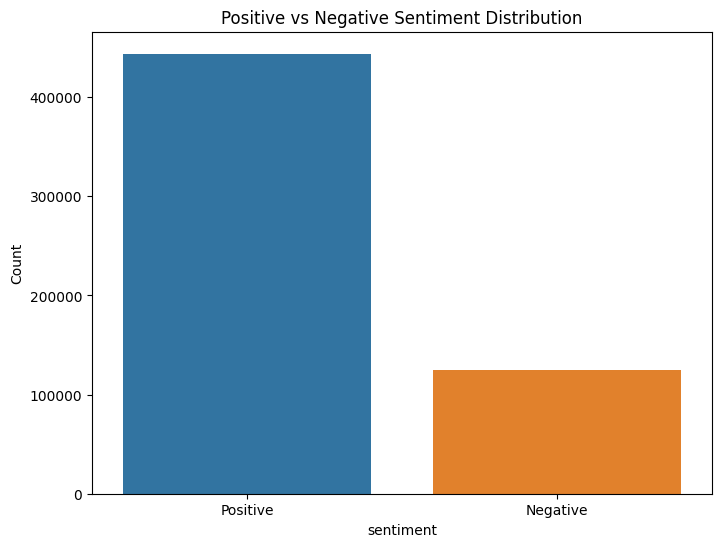

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df_reviews['sentiment'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_reviews)
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.title('Positive vs Negative Sentiment Distribution')
plt.savefig('Positive vs Negative Sentiment Distribution.png', dpi=300)


print(sentiment_counts)


Resampling Techniques: Undersampling the majority class (positive)!



In [4]:
#%pip install imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler

# Separate features and target variable
X = df_reviews['review']
y = df_reviews['sentiment']

# Create the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Perform undersampling
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with the undersampled data
df_resampled = pd.DataFrame({'review': X_resampled.flatten(), 'sentiment': y_resampled})

# Perform undersampling
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

# Check the balanced distribution
print(df_resampled['sentiment'].value_counts())

Negative    124677
Positive    124677
Name: sentiment, dtype: int64


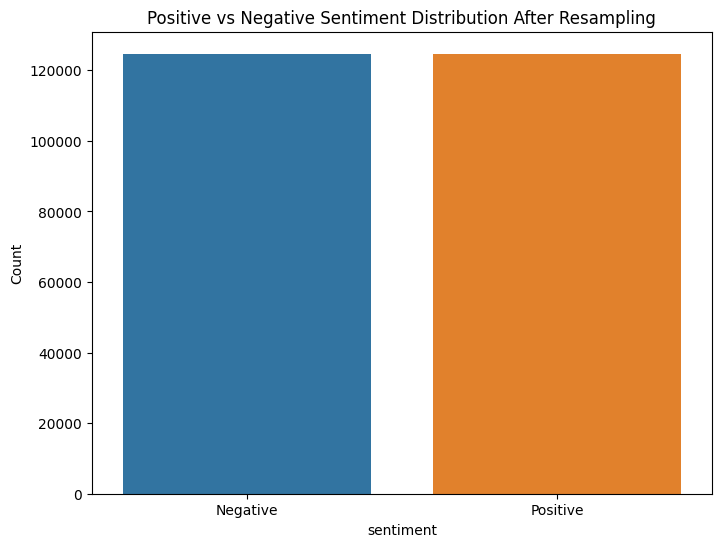

In [5]:
# Count the occurrences of each sentiment
sentiment_counts = df_resampled['sentiment'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_resampled)
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.title('Positive vs Negative Sentiment Distribution After Resampling')
plt.savefig('Positive vs Negative Sentiment Distribution After Resampling.png', dpi=300)

In [6]:
df_resampled.to_csv('resampled_data.csv', index=False)
#df_hidden.to_csv('hidden_data.csv', index=False)

Data Preprocessing

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):

    return TAG_RE.sub('', text)

In [9]:
from nltk.corpus import stopwords

def preprocess_text(sen):

    sentence = sen.lower()

    sentence = remove_tags(sentence)

    #removing punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    #removing single characters
    sentence = re.sub(r"\s+[^a-zA-Z]\s+", ' ', sentence)

    #removing multiple space
    sentence = re.sub(r'\s+', ' ', sentence)

    #remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence


In [11]:
# Separate positive and negative instances
positive_df = df_resampled[df_resampled['sentiment'] == 'Positive']
negative_df = df_resampled[df_resampled['sentiment'] == 'Negative']

# Randomly select 1500 positive and negative instances for testing
positive_test = positive_df.sample(n=124677, random_state=42)
negative_test = negative_df.sample(n=124677, random_state=42)

# Concatenate the test dataframes
test_df = pd.concat([positive_test, negative_test])

In [12]:
from tqdm import tqdm

X = []

sentences = list(test_df['review'])

for sen in tqdm(sentences):
    X.append(preprocess_text(sen))

100%|██████████| 249354/249354 [03:35<00:00, 1156.23it/s]


In [13]:
#sample review

X[0]

'tea awesome little lighter standard green tea still great health benefits stash quality tea trouble finding blend green white tea store shipped every months great way save time money '

Converting sentiment to 0, 1

In [15]:
import numpy as np

y = test_df['sentiment']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))

In [16]:
#the train to train the model and the test to evaluate how well it performs
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.20, random_state=42)

### Preparing Embedding Layer

Lets now convert our textual data into numeric form. Its then used as the first layer for the dl models in keras

In [17]:
#Embedding layer expects the words to be in numeric form
#USING TOKENIZER
#fit on text trains the tokenizer
#text to sequence converts text to numeric form

#%pip install tensorflow
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation, Dropout, Dense
#from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

##### + 1 is added to the result of len(word_tokenizer.word_index) to account for an additional dimension.

##### This additional dimension is typically reserved for special tokens or out-of-vocabulary (OOV) words, for which there might not be any pre-trained word embeddings available. 

##### By adding 1 to the vocabulary length, you ensure that you have a slot for these words.

In [18]:
#adding 1 to store dimensions for words which no pretrained word embedding exist

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

77598

Padding is important because neural networks typically require fixed-size inputs.

By padding the sequences to a fixed length, you ensure that all input sequences have the same shape, which allows them to be processed in batches efficiently.

It also ensures compatibility with the network architecture, as the input layer expects a consistent shape.

In [19]:
#Padding all reviews to fixed lenght 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen = maxlen)

In the provided code snippet, the code is loading pre-trained GloVe word embeddings from a text file named 'a2_glove.6B.100d.txt' and creating an embeddings dictionary. 

In [20]:
# load glove word embeddings and create embeddings dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding = "utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

In [21]:
#create embedding matrix having 100 collums
#containing 100 dimensional glove word embeddings for all words in corpus

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(77598, 100)

### MODELS TRAINING

Simple Neural Network

In [23]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [24]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          7759800   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 7769801 (29.64 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 7759800 (29.60 MB)
_________________________________________________________________
None


In [25]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
1247/1247 [==============================] - 13s 10ms/step - loss: 0.5527 - acc: 0.7250 - val_loss: 0.5259 - val_acc: 0.7497
Epoch 2/6
1247/1247 [==============================] - 11s 9ms/step - loss: 0.5095 - acc: 0.7590 - val_loss: 0.5421 - val_acc: 0.7465
Epoch 3/6
1247/1247 [==============================] - 12s 9ms/step - loss: 0.4996 - acc: 0.7653 - val_loss: 0.5348 - val_acc: 0.7510
Epoch 4/6
1247/1247 [==============================] - 12s 10ms/step - loss: 0.4945 - acc: 0.7693 - val_loss: 0.5460 - val_acc: 0.7480
Epoch 5/6
1247/1247 [==============================] - 12s 9ms/step - loss: 0.4907 - acc: 0.7706 - val_loss: 0.5394 - val_acc: 0.7519
Epoch 6/6
1247/1247 [==============================] - 12s 9ms/step - loss: 0.4893 - acc: 0.7729 - val_loss: 0.5439 - val_acc: 0.7509


In [26]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

1559/1559 [==============================] - 8s 5ms/step - loss: 0.5445 - acc: 0.7470


In [27]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5445172190666199
Test Accuracy: 0.7470072507858276


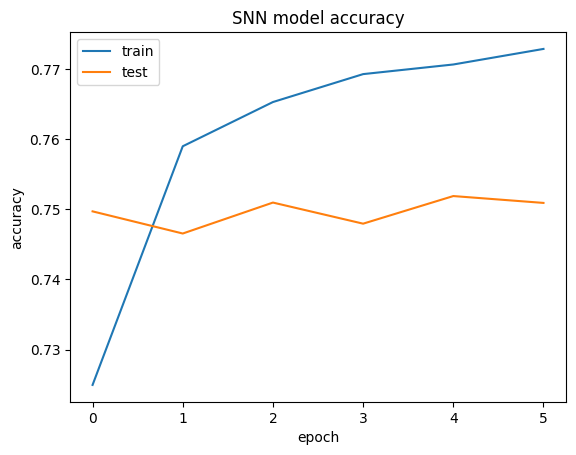

In [28]:
# Model Performance Charts

import matplotlib.pyplot as plt
# Model Performance Charts

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('SNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('SNN_accuracy per epoch', dpi=300)

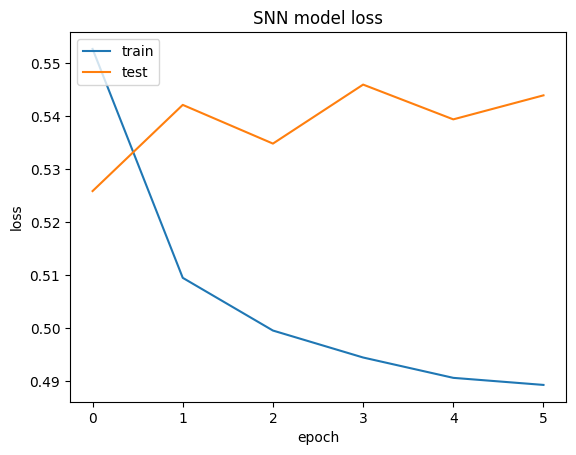

In [29]:
# Model Performance Charts

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('SNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('SNN_loss per epoch', dpi=300)

### Convolutional Neural Network

In [30]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [31]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          7759800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7824057 (29.85 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 7759800 (29.60 MB)
_________________________________________________________________
None


In [32]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
1247/1247 [==============================] - 102s 81ms/step - loss: 0.4347 - acc: 0.7970 - val_loss: 0.3755 - val_acc: 0.8344
Epoch 2/6
1247/1247 [==============================] - 106s 85ms/step - loss: 0.3408 - acc: 0.8544 - val_loss: 0.3491 - val_acc: 0.8491
Epoch 3/6
1247/1247 [==============================] - 106s 85ms/step - loss: 0.2919 - acc: 0.8801 - val_loss: 0.3359 - val_acc: 0.8577
Epoch 4/6
1247/1247 [==============================] - 104s 84ms/step - loss: 0.2552 - acc: 0.8983 - val_loss: 0.3414 - val_acc: 0.8569
Epoch 5/6
1247/1247 [==============================] - 94s 75ms/step - loss: 0.2267 - acc: 0.9111 - val_loss: 0.3373 - val_acc: 0.8637
Epoch 6/6
1247/1247 [==============================] - 88s 70ms/step - loss: 0.2039 - acc: 0.9221 - val_loss: 0.3470 - val_acc: 0.8638


In [33]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

1559/1559 [==============================] - 18s 11ms/step - loss: 0.3491 - acc: 0.8623


In [34]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3490977883338928
Test Accuracy: 0.8622847199440002


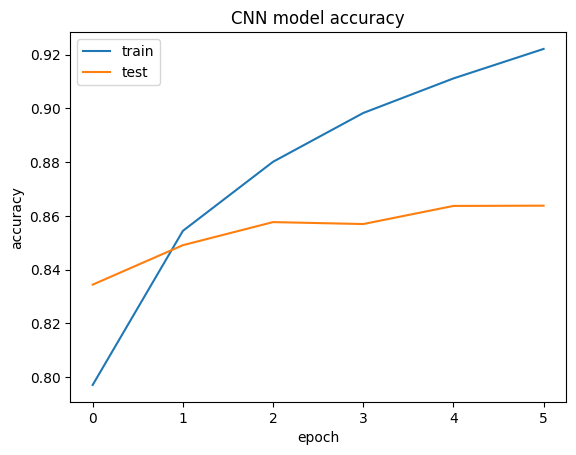

In [35]:
# Model Performance Charts

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.savefig('CNN_accuracy per epoch', dpi=300)

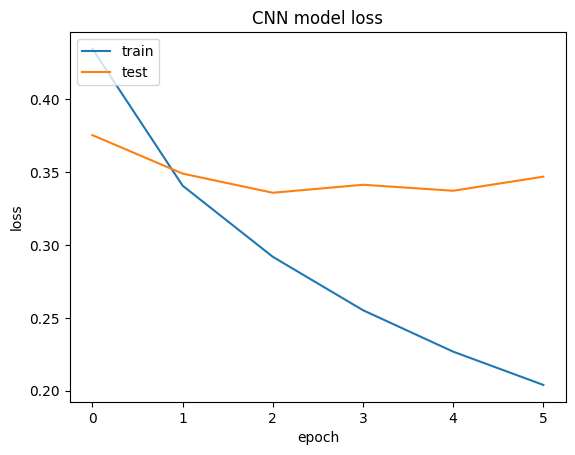

In [36]:
# Model Performance Charts

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.savefig('CNN_loss per epoch', dpi=300)

### Recurrent Neural Network (LSTM)

In [37]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [38]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          7759800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7877177 (30.05 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 7759800 (29.60 MB)
_________________________________________________________________
None


In [39]:
#Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
1247/1247 [==============================] - 399s 311ms/step - loss: 0.6634 - acc: 0.5608 - val_loss: 0.4871 - val_acc: 0.7701
Epoch 2/6
1247/1247 [==============================] - 390s 312ms/step - loss: 0.4311 - acc: 0.8006 - val_loss: 0.4055 - val_acc: 0.8137
Epoch 3/6
1247/1247 [==============================] - 379s 304ms/step - loss: 0.3715 - acc: 0.8348 - val_loss: 0.3650 - val_acc: 0.8383
Epoch 4/6
1247/1247 [==============================] - 377s 303ms/step - loss: 0.3350 - acc: 0.8534 - val_loss: 0.3342 - val_acc: 0.8571
Epoch 5/6
1247/1247 [==============================] - 367s 294ms/step - loss: 0.3067 - acc: 0.8686 - val_loss: 0.3271 - val_acc: 0.8622
Epoch 6/6
1247/1247 [==============================] - 353s 283ms/step - loss: 0.2813 - acc: 0.8817 - val_loss: 0.3204 - val_acc: 0.8673


In [40]:
#Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

1559/1559 [==============================] - 77s 49ms/step - loss: 0.3155 - acc: 0.8692


In [41]:
#Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31545889377593994
Test Accuracy: 0.8691624402999878


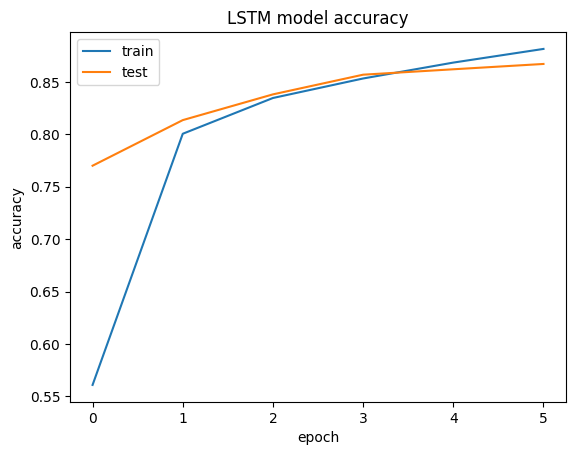

In [42]:
#Μodel Performance Charts

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('LSTM_accuracy per epoch', dpi=300)

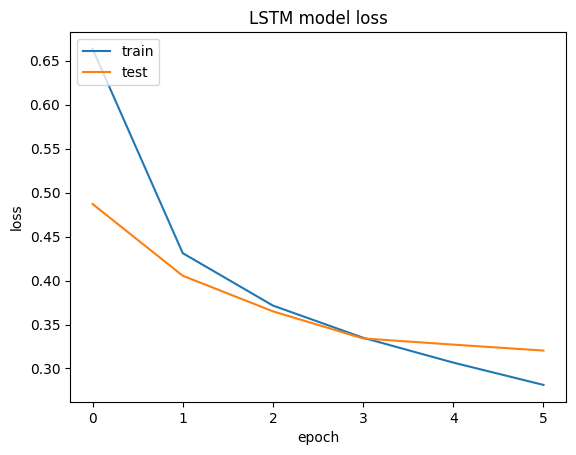

In [43]:
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('LSTM_loss per epoch', dpi=300)

In [44]:
#Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

c:\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
